# Project: Building a Proactive Psychology Tutor Engine

**Goal:** This notebook retrains the `proactive-tutor-engine`'s models using the psychology-focused datasets from the `psychology-data-pipeline`. The final product will be an intelligent tutor specialized in the domain of psychology.

**Methodology:**
1.  **Data Ingestion:** Assumes the `normalize_psych_data.py` script has been run to generate a clean, unified dataset.
2.  **Student Interaction Simulation:** Creates a realistic, time-series log from the static Q&A data, which is essential for training our temporal models.
3.  **Feature Engineering:** Engineers historical features (e.g., prior attempts) and textual features (e.g., question length) from the data.
4.  **BKT Model Training:** Trains a Bayesian Knowledge Tracing (BKT) model on a specific psychology "skill" to track long-term student mastery.
5.  **LGBM Model Training:** Trains an enriched LightGBM "Success Predictor" to make tactical, short-term predictions of student success.
6.  **Showcase Simulation:** Demonstrates the fully retrained tutor, combining the strategic BKT model and the tactical LGBM model to make intelligent, proactive help decisions.

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import re
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from pyBKT.models import Model
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define Paths and Constants ---
PROCESSED_DATA_DIR = 'data/processed/'
MODELS_DIR = 'models/'
os.makedirs(MODELS_DIR, exist_ok=True)

# --- THIS IS THE CHANGE ---
# Point to the new data file that includes the pre-computed embeddings
PSYCH_DATA_FILE = os.path.join(PROCESSED_DATA_DIR, "psychology_data_with_embeddings.parquet")
# --- END OF CHANGE ---

print("Setup complete.")

Setup complete.


### Data Ingestion and Student Interaction Simulation

This is the most critical step. First, we ensure our source psychology data exists by running the `normalize_psych_data.py` script.

Then, because the Tutor Engine's models require sequential student interaction data (which our Q&A dataset lacks), we create a **Student Interaction Simulator**. This function generates a realistic, time-series log from the static data, creating simulated students, their attempts, success/failure, and response times. This makes training our temporal models possible.

In [2]:
# Import the simulation function from our new module
from feature_engineering import simulate_student_interactions

# --- Step 1: Load the Psychology Dataset ---
if not os.path.exists(PSYCH_DATA_FILE):
    print(f"FATAL: Psychology data file not found at '{PSYCH_DATA_FILE}'. Please run `compute_embeddings.py` first.")
    df_psych = None
else:
    df_psych = pd.read_parquet(PSYCH_DATA_FILE)
    df_psych['problem_id'] = df_psych.index.astype(str)
    print(f"Successfully loaded {len(df_psych):,} psychology Q&A pairs.")
    print("\nDataset sources (our 'skills'):")
    print(df_psych['source'].value_counts())

# --- Step 2: Use the imported Student Interaction Simulator ---
if df_psych is not None:
    df_simulated_log = simulate_student_interactions(df_qa=df_psych, num_students=500, interactions_per_student=50)

Successfully loaded 401,374 psychology Q&A pairs.

Dataset sources (our 'skills'):
source
BoltMonkey/psychology-question-answer                        197179
Gragroo/psychology-question-answer_psygpt_with_validation    193235
PsychoLexQA                                                    9803
MMLU/professional_psychology                                    612
MMLU/high_school_psychology                                     545
Name: count, dtype: int64

Simulating interaction logs for 500 students...
Simulation complete. Generated 25,000 interactions.


### Feature Engineering for Tutor Models

Now that we have a simulated time-series log, we use our centralized `create_features` function to engineer the features needed for the LGBM model. We treat the `source` of the data as the "skill" for our models.

In [3]:
# Import the feature creation function
from feature_engineering import create_features

if 'df_simulated_log' in locals() and not df_simulated_log.empty:
    print("\nStarting Feature Engineering...")

    # First, create and save the encoder that will be used by the function
    skill_encoder = LabelEncoder()
    skill_encoder.fit(df_simulated_log['source'])
    joblib.dump(skill_encoder, os.path.join(MODELS_DIR, 'psych_skill_encoder.joblib'))

    # Now, create the features using the centralized function
    df_model_data = create_features(df_simulated_log, skill_encoder)
    
    print(f"Feature engineering complete. {len(df_model_data):,} interactions ready for modeling.")
else:
    print("Simulated data not available. Cannot proceed.")


Starting Feature Engineering...
Feature engineering complete. 24,500 interactions ready for modeling.


In [4]:
if 'df_model_data' in locals() and not df_model_data.empty:
    print("\n--- Training BKT 'Strategist' Models for Top Skills ---")
    
    # Get the top 3 most common skills (datasets)
    top_skills = df_psych['source'].value_counts().nlargest(3).index.tolist()
    bkt_models = {}

    for skill_name in top_skills:
        print(f"\n--- Training BKT for skill: {skill_name} ---")
        skill_questions = df_psych[df_psych['source'] == skill_name]
        
        bkt_simulated_log = simulate_student_interactions(df_qa=skill_questions, num_students=100, interactions_per_student=30)
        bkt_simulated_log['order_id'] = bkt_simulated_log.groupby('student_id').cumcount() + 1
        bkt_df_formatted = bkt_simulated_log.rename(columns={'student_id': 'user_id', 'source': 'skill_name', 'is_correct': 'correct'})
        
        # You can tune these defaults per skill if desired
        defaults = {'prior': 0.5, 'learns': 0.1, 'guesses': 0.1, 'slips': 0.2, 'forgets': 0.01}
        bkt_model = Model(seed=42, num_fits=1, defaults=defaults)
        bkt_model.fit(data=bkt_df_formatted, skills=skill_name)
        
        # Save the model with a skill-specific name
        # Replace invalid filename characters
        safe_skill_name = re.sub(r'[\\/*?:"<>|]',"_", skill_name)
        model_path = os.path.join(MODELS_DIR, f'bkt_model_{safe_skill_name}.pkl')
        bkt_model.save(model_path)
        print(f"BKT model for '{skill_name}' saved to: {model_path}")
        bkt_models[skill_name] = bkt_model

    # For the showcase, we'll just use the first one trained
    SKILL_TO_MODEL = top_skills[0] if top_skills else None
else:
    print("Modeling data not available. Skipping BKT training.")
    bkt_model = None


--- Training BKT 'Strategist' Models for Top Skills ---

--- Training BKT for skill: BoltMonkey/psychology-question-answer ---

Simulating interaction logs for 100 students...
Simulation complete. Generated 3,000 interactions.
BKT model for 'BoltMonkey/psychology-question-answer' saved to: models/bkt_model_BoltMonkey_psychology-question-answer.pkl

--- Training BKT for skill: Gragroo/psychology-question-answer_psygpt_with_validation ---

Simulating interaction logs for 100 students...
Simulation complete. Generated 3,000 interactions.
BKT model for 'Gragroo/psychology-question-answer_psygpt_with_validation' saved to: models/bkt_model_Gragroo_psychology-question-answer_psygpt_with_validation.pkl

--- Training BKT for skill: PsychoLexQA ---

Simulating interaction logs for 100 students...
Simulation complete. Generated 3,000 interactions.
BKT model for 'PsychoLexQA' saved to: models/bkt_model_PsychoLexQA.pkl



--- Training ENRICHED LGBM 'Success Predictor' Model ---
Training on 19,600 interactions with 390 features.
[LightGBM] [Info] Number of positive: 5557, number of negative: 14043
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98624
[LightGBM] [Info] Number of data points in the train set: 19600, number of used features: 390
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.283520 -> initscore=-0.927066
[LightGBM] [Info] Start training from score -0.927066

Enriched LGBM Model AUC on validation set: 0.9115
Enriched LGBM 'Tactician' model saved to: models/lgbm_psych_predictor_enriched.joblib

--- Feature Importance for Enriched Q&A Tactician ---


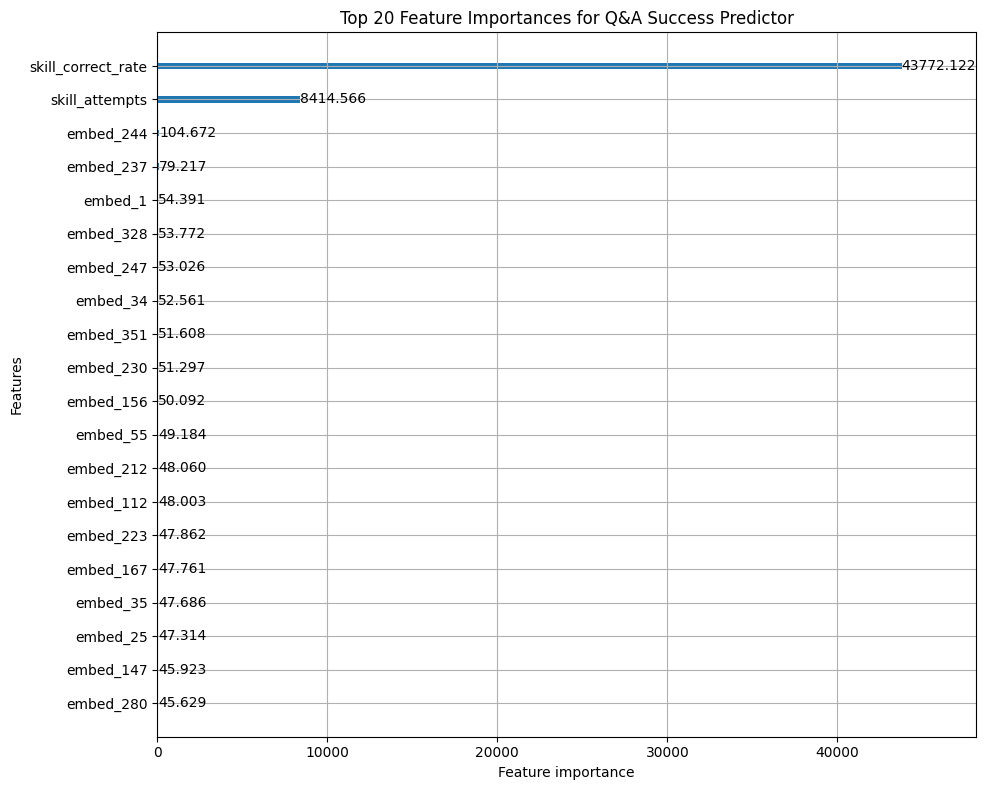

In [5]:
if 'df_model_data' in locals() and not df_model_data.empty:
    print("\n--- Training ENRICHED LGBM 'Success Predictor' Model ---")

    # --- THIS IS THE CHANGE ---
    # Get the list of embedding column names (assumes 'all-MiniLM-L6-v2' which has 384 dimensions)
    embedding_cols = [f'embed_{i}' for i in range(384)]

    # Add the new embedding columns to the list of features
    base_features = ['prior_response_time', 'prior_is_correct', 'skill_id_encoded', 'skill_attempts', 'skill_correct_rate', 'question_length']
    features = base_features + embedding_cols
    # --- END OF CHANGE ---

    target = 'is_correct'

    student_ids = df_model_data['student_id'].unique()
    train_student_ids, val_student_ids = train_test_split(student_ids, test_size=0.2, random_state=42)
    train_df, val_df = df_model_data[df_model_data['student_id'].isin(train_student_ids)], df_model_data[df_model_data['student_id'].isin(val_student_ids)]
    X_train, y_train = train_df[features], train_df[target]
    X_val, y_val = val_df[features], val_df[target]

    print(f"Training on {len(X_train):,} interactions with {len(features)} features.")

    lgbm_predictor = lgb.LGBMClassifier(objective='binary', metric='auc', random_state=42)
    lgbm_predictor.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(10, verbose=False)])

    auc = roc_auc_score(y_val, lgbm_predictor.predict_proba(X_val)[:, 1])
    print(f"\nEnriched LGBM Model AUC on validation set: {auc:.4f}")

    lgbm_model_path = os.path.join(MODELS_DIR, 'lgbm_psych_predictor_enriched.joblib')
    joblib.dump(lgbm_predictor, lgbm_model_path)
    print(f"Enriched LGBM 'Tactician' model saved to: {lgbm_model_path}")
    
    print("\n--- Feature Importance for Enriched Q&A Tactician ---")
    # Note: Plotting importance with 390 features can be messy. Let's show the top 20.
    lgb.plot_importance(lgbm_predictor, figsize=(10, 8), max_num_features=20, importance_type='gain', title='Top 20 Feature Importances for Q&A Success Predictor')
    plt.tight_layout()
    plt.show()
else:
    print("Modeling data not available. Skipping LGBM training.")
    lgbm_predictor = None

In [9]:
# --- Showcase Pre-Flight Checks ---
print("\n--- Running Showcase Pre-Flight Checks ---")
showcase_ready = True

# Check 1: Is the LGBM Tactician model trained?
if 'lgbm_predictor' not in locals() or lgbm_predictor is None:
    print("❌ ERROR: The LGBM 'Tactician' model ('lgbm_predictor') was not trained. Cannot run showcase.")
    showcase_ready = False

# Check 2: Are the BKT Strategist models trained?
if 'bkt_models' not in locals() or not bkt_models:
    print("❌ ERROR: The BKT 'Strategist' models ('bkt_models') were not trained. Showcase will run without strategic insights.")
    # We can proceed without BKT, but we'll disable the check.
    # Set bkt_models to an empty dict to prevent errors later.
    bkt_models = {}

# Check 3: Do we have the source dataframe for question lookups?
if 'df_psych' not in locals() or df_psych.empty:
    print("❌ ERROR: The main psychology dataframe ('df_psych') is not available. Cannot look up question text.")
    showcase_ready = False

# --- Run Showcase if All Checks Pass ---
if showcase_ready:
    print("✅ SUCCESS: All pre-flight checks passed. Starting Final Showcase Simulation...")

    # Get the list of embedding column names
    embedding_cols = [f'embed_{i}' for i in range(384)]

    def run_psychology_tutor(student_state_features, student_bkt_data, skill_for_bkt_check):
        assert len(student_state_features.columns) == 390, f"Showcase input has {len(student_state_features.columns)} features, but model expects 390."
        
        prob_success = lgbm_predictor.predict_proba(student_state_features)[:, 1][0]
        print(f"\nLGBM TACTICAL Check: Immediate success probability is {prob_success:.1%}")
        
        hint_level = -1
        if prob_success < 0.45:
            print(" -> Tactical Decision: High struggle detected. Intervene with a direct hint.")
            hint_level = 1
        elif prob_success < 0.65:
            print(" -> Tactical Decision: Mild struggle detected. Offer a hint passively.")
            hint_level = 0
        else:
            print(" -> Tactical Decision: Student is likely to succeed. No intervention needed.")

        # Check if BKT models exist and if the specific skill has a model
        if bkt_models and skill_for_bkt_check in bkt_models and student_bkt_data is not None and not student_bkt_data.empty:
            bkt_model_for_skill = bkt_models[skill_for_bkt_check]
            mastery_prob = bkt_model_for_skill.predict(data=student_bkt_data)['state_predictions'].iloc[-1]
            print(f"BKT STRATEGIC Check: Long-term mastery of '{skill_for_bkt_check}' is {mastery_prob:.1%}")
        else:
            print(f"BKT STRATEGIC Check: No BKT history or model available for student on '{skill_for_bkt_check}'.")

        question_index = int(student_state_features.index[0])
        question = df_psych.loc[question_index, 'question']
        answer_as_hint = df_psych.loc[question_index, 'answer']
        
        print("-" * 25)
        print(f"QUESTION: {question[:150]}...")
        if hint_level == 1: print(f"FINAL ACTION: Proactive Hint -> {answer_as_hint[:150]}...")
        elif hint_level == 0: print("FINAL ACTION: Passive Offer -> 'Looks a bit tricky. Let me know if you need a hint!'")
        else: print("FINAL ACTION: Encouragement -> 'You've got this! Keep up the great work.'")
        print("-" * 25)

    # --- SCENARIO 1: Confident Student ---
    print("\n\n--- SCENARIO 1: Confident Student ---")
    question_index_1 = df_psych.index[0]
    skill_for_scenario_1 = df_psych.loc[question_index_1, 'source']
    
    base_confident_features = pd.DataFrame({'prior_response_time': [20.0], 'prior_is_correct': [1.0], 'skill_id_encoded': [skill_encoder.transform([skill_for_scenario_1])[0]], 'skill_attempts': [10], 'skill_correct_rate': [0.9], 'question_length': [len(df_psych.loc[question_index_1, 'question'])]})
    question_embeddings_1 = df_psych.loc[[question_index_1], embedding_cols].reset_index(drop=True)
    confident_features = pd.concat([base_confident_features, question_embeddings_1], axis=1)
    confident_features.index = [question_index_1]
    
    run_psychology_tutor(confident_features, None, skill_for_scenario_1)

    # --- SCENARIO 2: Struggling Student ---
    print("\n\n--- SCENARIO 2: Struggling Student ---")
    
    # Use the first skill for which we trained a BKT model, if any exist
    if bkt_models:
        SKILL_TO_DEMO_BKT = list(bkt_models.keys())[0]
        
        question_index_2 = df_psych[df_psych['source'] == SKILL_TO_DEMO_BKT].index[0]
        base_struggling_features = pd.DataFrame({'prior_response_time': [95.0], 'prior_is_correct': [0.0], 'skill_id_encoded': [skill_encoder.transform([SKILL_TO_DEMO_BKT])[0]], 'skill_attempts': [5], 'skill_correct_rate': [0.2], 'question_length': [len(df_psych.loc[question_index_2, 'question'])]})
        question_embeddings_2 = df_psych.loc[[question_index_2], embedding_cols].reset_index(drop=True)
        struggling_features = pd.concat([base_struggling_features, question_embeddings_2], axis=1)
        struggling_features.index = [question_index_2]
        
        student_bkt_history = val_df[val_df['source'] == SKILL_TO_DEMO_BKT].rename(columns={'student_id': 'user_id', 'source': 'skill_name', 'is_correct': 'correct'})
        
        if not student_bkt_history.empty:
            run_psychology_tutor(struggling_features, student_bkt_history, SKILL_TO_DEMO_BKT)
        else:
            print(f"Could not find a student with history for '{SKILL_TO_DEMO_BKT}' in the validation set to run showcase.")
    else:
        print("\nSkipping BKT part of Scenario 2 because no BKT models were trained.")

else:
    print("\nShowcase aborted due to failed pre-flight checks. Please review error messages above.")


--- Running Showcase Pre-Flight Checks ---
✅ SUCCESS: All pre-flight checks passed. Starting Final Showcase Simulation...


--- SCENARIO 1: Confident Student ---

LGBM TACTICAL Check: Immediate success probability is 70.1%
 -> Tactical Decision: Student is likely to succeed. No intervention needed.
BKT STRATEGIC Check: No BKT history or model available for student on 'BoltMonkey/psychology-question-answer'.
-------------------------
QUESTION: How does Freud's psychoanalytic theory explain human behaviour?...
FINAL ACTION: Encouragement -> 'You've got this! Keep up the great work.'
-------------------------


--- SCENARIO 2: Struggling Student ---

LGBM TACTICAL Check: Immediate success probability is 25.6%
 -> Tactical Decision: High struggle detected. Intervene with a direct hint.
BKT STRATEGIC Check: Long-term mastery of 'BoltMonkey/psychology-question-answer' is 2.4%
-------------------------
QUESTION: How does Freud's psychoanalytic theory explain human behaviour?...
FINAL ACTION: